In [72]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import math 

from typing import Tuple 
from mlxtend.frequent_patterns import fpgrowth, association_rules

import util_consts as constants
import helpers 

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

INFILE = '/home/grace/work/SEER/data/SEER_2010_2020_RICH.clean.tsv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
maintable = pd.read_csv(INFILE, sep='\t', header=0)
c_counts = maintable['cancer_group'].value_counts()
valid = set(c_counts[c_counts>=5000].index.to_list())
maintable = maintable[maintable['cancer_group'].isin(valid)]
maintable = maintable[maintable['cancer_group']!='Brain']
maintable = maintable[maintable['hist_group']!='unspecified neoplasms']
table = maintable.copy()

/tmp/ipykernel_18211/3319844833.py:1: DtypeWarning: Columns (20,21,22,27,28,29,35,36,37,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  maintable = pd.read_csv(INFILE, sep='\t', header=0)


### Cleaning / Casting / Formatting

Initial custom items

In [74]:
# local ln status
table = helpers.format_local_ln_met(table)

# age categorical -> float
mask = table['age'].notna()
table.loc[mask, 'age_NUM'] = table.loc[mask, 'age'].apply(helpers.cast_str_to_float_age)

# age float -> categorical (rebinning)
table.loc[mask, 'age_CAT'] = table.loc[mask, 'age_NUM'].apply(helpers.cast_float_age_to_bins, binwidth=10)


Renaming

In [75]:
namelut = {

    # pure categorical
    'cancer_group': 'cancer_group_CAT',
    'hist_group': 'hist_group_CAT',
    'HER2_type': 'HER2_type_CAT',
    'sex': 'sex_CAT',

    # pure bool
    'local_ln_met': 'local_ln_met_BOOL',
    'distant_ln_met': 'distant_ln_met_BOOL',
    'brain_met': 'brain_met_BOOL',
    'bone_met': 'bone_met_BOOL',
    'liver_met': 'liver_met_BOOL',
    'lung_met': 'lung_met_BOOL',
    'other_met': 'other_met_BOOL',
    'any_met': 'any_met_BOOL',
    'ulceration': 'ulceration_BOOL',
    'perineural_invasion': 'perineural_invasion_BOOL',
    'adrenal_involvement': 'adrenal_involvement_BOOL',
    'major_vein_involvement': 'major_vein_involvement_BOOL',
    'capsule_invasion': 'capsule_invasion_BOOL',
    'chr19q_loh': 'chr19q_loh_BOOL',
    'chr1p_loh': 'chr1p_loh_BOOL',
    'pleural_effusion': 'pleural_effusion_BOOL',
    'B_symptoms': 'B_symptoms_BOOL',

    # categorical (mappable to NUM)
    'TSTAGE_STD': 'TSTAGE_CAT',
    'NSTAGE_STD': 'NSTAGE_CAT',
    'GSTAGE_STD': 'GSTAGE_CAT',
    'GRADE_STD': 'GRADE_CAT',
    'hGC_post_orchiectomy_elevation': 'hGC_elevation_post_orchiectomy_CAT',
    'LDH_post_orchiectomy_elevation': 'LDH_elevation_post_orchiectomy_CAT',
    'HER2_status': 'HER2_status_CAT',
    'peripheral_blood_involvement': 'peripheral_blood_involvement_CAT',
    'peritoneal_cytology': 'peritoneal_cytology_CAT',
    'pleural_invasion': 'pleural_invasion_CAT',
    
    # categorical (mappable to BOOL)
    'LDH_pretreatment': 'LDH_elevated_pretreat_CAT',
    'CEA_pretreat': 'CEA_elevated_pretreat_CAT',
    'ovarian_CA125': 'CA125_elevated_CAT',
    'AFP_pretreat_category': 'AFP_elevated_pretreat_CAT',
    'fibrosis_score': 'fibrosis_score_CAT',
    
    # continuous (always mappable to CAT and BOOL)
    'breslow_thick': 'breslow_thick_NUM',
    'mitotic_rate_melanoma': 'mitotic_rate_NUM',
    'PSA': 'PSA_NUM',
    'gleason': 'gleason_NUM',
    'tumor_deposits': 'tumor_deposits_NUM',
    'AFP_post_orchiectomy': 'AFP_post_orchiectomy_NUM',
    
}
table = table.rename(columns=namelut)

Casting Categorical -> Numeric

In [76]:
# functions
funclut = {
    'TSTAGE_CAT': helpers.cast_tstage_to_float,
    'NSTAGE_CAT': helpers.cast_nstage_to_float,
    'GSTAGE_CAT': helpers.cast_gstage_to_float,
    'GRADE_CAT': helpers.cast_grade_to_float,
    'hGC_elevation_post_orchiectomy_CAT': helpers.cast_hGC_to_float,
    'LDH_elevation_post_orchiectomy_CAT': helpers.cast_LDH_to_float,
    'HER2_status_CAT': helpers.cast_HER2_to_float,
    'peripheral_blood_involvement_CAT': helpers.cast_peripheral_blood_to_float,
    'peritoneal_cytology_CAT': helpers.cast_peritoneal_cytology_to_float,
    'pleural_invasion_CAT': helpers.cast_pleural_invasion_to_float,
}

# apply
for field, func in funclut.items():
    newfield = field.replace('_CAT', '_NUM')
    if field == 'GRADE_CAT':
        mask = table['GRADE_CAT'].isin(['G1', 'G2', 'G3', 'G4'])
    else:
        mask = table[field].notna()
    table.loc[mask, newfield] = table.loc[mask, field].apply(func)
    # print()
    # print(table[field].value_counts())
    # print(table[newfield].value_counts())



Casting Categorical -> Bool

In [77]:
# categorical (mappable to BOOL)
funclut = {
    'LDH_elevated_pretreat_CAT': helpers.cast_2level_elevation_to_bool,
    'CEA_elevated_pretreat_CAT': helpers.cast_2level_elevation_to_bool,
    'AFP_elevated_pretreat_CAT': helpers.cast_2level_elevation_to_bool,
    'CA125_elevated_CAT': helpers.cast_2level_elevation_to_bool,
    'fibrosis_score_CAT': helpers.cast_fibrosis_to_bool,
}

# apply
for field, func in funclut.items():
    mask = table[field].notna()
    newfield = field.replace('_CAT', '_BOOL')
    table.loc[mask, newfield] = table.loc[mask, field].apply(func)
    # print()
    # print(table[field].value_counts())
    # print(table[newfield].value_counts())



Casting Continuous -> Numeric & Bool

In [78]:
# continuous (always mappable to CAT and BOOL)
fields = [
    'breslow_thick_NUM',
    'mitotic_rate_NUM',
    'PSA_NUM',
    'gleason_NUM',
    'tumor_deposits_NUM',
    'AFP_post_orchiectomy_NUM',
]

# mapping to 3 levels (categorical)
for predictor in fields:
    newfield = predictor.replace('_NUM', '_CAT')
    mask = table[predictor].notna()
    table.loc[mask, newfield] = helpers.categorise(table.loc[mask, predictor], preferred_q=3)
    # sns.histplot(table, x=newfield)
    # plt.show()

# mapping to 2 levels (high bool)
for predictor in fields:
    newfield = predictor.replace('_NUM', '_BOOL')
    mask = table[predictor].notna()
    table.loc[mask, f"{newfield}_tmp"] = helpers.categorise(table.loc[mask, predictor], preferred_q=2)
    table.loc[mask, newfield] = table.loc[mask, f"{newfield}_tmp"].apply(lambda x: False if 'low' in x else True)
    table = table.drop(f"{newfield}_tmp", axis=1)
    # print()
    # print(table[newfield].value_counts())



FALLBACK TO GRACE METHOD
FALLBACK TO GRACE METHOD


Casting uncasted BOOL to NUM

In [79]:
boolfields = [col for col in table.columns if col.endswith('_BOOL')]
numfields = [col for col in table.columns if col.endswith('_NUM')]
for field in boolfields:
    if field.replace('_BOOL', '_NUM') in numfields:
        print(f"ignoring {field} conversion to numeric.")
        continue 
    newfield = field.replace('_BOOL', '_NUM')
    mask = table[field].notna()
    table.loc[mask, newfield] = table.loc[mask][field].map({True: 1.0, False: 0.0})

ignoring breslow_thick_BOOL conversion to numeric.
ignoring mitotic_rate_BOOL conversion to numeric.
ignoring PSA_BOOL conversion to numeric.
ignoring gleason_BOOL conversion to numeric.
ignoring tumor_deposits_BOOL conversion to numeric.
ignoring AFP_post_orchiectomy_BOOL conversion to numeric.


Reporting fields

In [80]:
query = 'local_ln_met'
catfield = f"{query}_CAT"
numfield = f"{query}_NUM"
boolfield = f"{query}_BOOL"
if catfield in table.columns:
    print()
    print(table[catfield].value_counts())
if numfield in table.columns:
    print()
    print(table[numfield].value_counts())
if boolfield in table.columns:
    print()
    print(table[boolfield].value_counts())


local_ln_met_NUM
0.0    2867334
1.0     820673
Name: count, dtype: int64

local_ln_met_BOOL
False    2867334
True      820673
Name: count, dtype: int64


In [81]:
basefields = sorted(list(set([col.replace('_CAT', '').replace('_BOOL', '').replace('_NUM', '') for col in table.columns])))

df = pd.DataFrame(data=False, index=basefields, columns=['CAT', 'NUM', 'BOOL'])
for field in basefields:
    if f"{field}_CAT" in table.columns:
        df.loc[field, 'CAT'] = True
    if f"{field}_NUM" in table.columns:
        df.loc[field, 'NUM'] = True
    if f"{field}_BOOL" in table.columns:
        df.loc[field, 'BOOL'] = True

df

,CAT,NUM,BOOL
AFP_elevated_pretreat,True,True,True
AFP_post_orchiectomy,True,True,True
B_symptoms,False,True,True
CA125_elevated,True,True,True
CEA_elevated_pretreat,True,True,True
COD,False,False,False
GRADE,True,True,False
GSTAGE,True,True,False
HER2_status,True,True,False
HER2_type,True,False,False


In [82]:
# catfields = [col for col in table.columns if col.endswith('_CAT')]
# boolfields = [col for col in table.columns if col.endswith('_BOOL')]
# numfields = [col for col in table.columns if col.endswith('_NUM')]

# ncols = 3
# if len(catfields) % ncols == 0:
#     nrows = len(catfields) // ncols
# else:
#     nrows = len(catfields) // ncols + 1

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
# for field, ax in zip(catfields, axes.flat):
#     sns.histplot(table, x=field, ax=ax)
#     ax.set_title(field)
# plt.tight_layout()
# plt.show()



### ML Models

Dtable generation

In [104]:

def gen_dtable_cancer_group(df: pd.DataFrame, cancer_group: str, response: str) -> pd.DataFrame:
    """
    creating DTable for logistic regression / decision tree:
    if only CAT field (no NUM/BOOL), one-hot encode.
    else, assert NUM field and use this. 
    """
    dfslice = df[df['cancer_group_CAT']==cancer_group].reset_index(drop=True).copy()
    dfslice = dfslice[dfslice[response].notna()]
    print()
    print(cancer_group)
    print(dfslice.shape)

    # remove low freq hist groups
    if 'hist_group' not in IGNORE[cancer_group]:
        MIN_OBSERVATIONS = 5
        MAX_HIST_GROUPS = 5
        hcounts = dfslice[dfslice[response]==True]['hist_group_CAT'].value_counts().sort_values(ascending=False)
        valid = hcounts[hcounts>=MIN_OBSERVATIONS].index.to_list()
        valid = valid[:MAX_HIST_GROUPS]
        print(f"Retaining the following histological categories")
        for val in valid:
            print(f"- {val} ({hcounts[val]} records)")
        # invalid = [x for x in hcounts.index if x not in valid]
        # if len(invalid) > 0:
        #     print()
        #     print(f"Removing the following histological categories")
        #     for val in invalid:
        #         print(f"- {val}")
        dfslice = dfslice[dfslice['hist_group_CAT'].isin(valid)].copy()
    
    # dtable
    dtable = pd.DataFrame(index=dfslice.index)

    # gather predictors
    basefields = sorted(list(set([col.replace('_CAT', '').replace('_BOOL', '').replace('_NUM', '') for col in dfslice.columns])))
    catpreds = []
    numpreds = []
    for field in basefields:
        # print(field)
        if field in IGNORE['universal']:
            continue 
        elif field in IGNORE[cancer_group]:
            continue 
        catfield = f"{field}_CAT"
        numfield = f"{field}_NUM"
        if numfield in dfslice.columns:
            if dfslice[numfield].notna().sum() > 0:
                numpreds.append(numfield)
        else:
            if catfield not in dfslice.columns:
                print(field, catfield, numfield)
            assert catfield in dfslice.columns
            if dfslice[catfield].notna().sum() > 0:
                catpreds.append(catfield)
    
    # lift numeric
    for pred in numpreds:
        dtable[pred] = dfslice[pred]
    
    # one-hot encode categorical
    for field in catpreds:
        fvals = sorted(list(dfslice[field].unique()))
        for val in fvals:
            dtable[val] = 0
            mask = dfslice[field]==val
            dtable.loc[mask, val] = 1

    # add reponse variable
    dtable[response] = dfslice[response]
    
    # filtering na values 
    print()
    print('Filtering NA values ---')
    print()
    print(f"Start: {dtable.shape[0]} records")
    for field in dtable.columns:
        irows = dtable.shape[0]
        dtable = dtable[dtable[field].notna()]
        frows = dtable.shape[0]
        print(f"{irows-frows} NA records removed for {field}")
    print(f"End: {dtable.shape[0]} records")
    
    print()
    print('Equalizing proportions ---')
    print()
    print(dtable[response].value_counts())
    dtable = helpers.equalise_proportions(dtable, response)
    print()
    print(dtable[response].value_counts())

    print()
    print('Removing predictors with now only single value ---')
    to_remove = []
    for field in dtable.columns:
        if dtable[field].nunique() < 2:
            to_remove.append(field)
    for field in to_remove:
        print(f"- {field}")
    dtable = dtable.drop(to_remove, axis=1)

    return dtable.copy()


# def map_3cat_to_numeric(text: str) -> float:
#     if 'low' in text:
#         return 0.0
#     elif 'mid' in text:
#         return 1.0
#     elif 'high' in text:
#         return 2.0
#     raise ValueError



In [107]:
RESPONSE = 'brain_met_BOOL'
IGNORE = {
    'universal': [
        'cancer_type',
        'cancer_group',
        'primary_type',
        'primary_group',
        'hist_type',
        'patient_id',
        'record_number',
        'behavior',
        'COD',
        'diagnosis_year',
        'death_year',
        'survival_months',
        'regional_nodes',
        'brain_met',
        'bone_met',
        'liver_met',
        'lung_met',
        'other_met',
        'any_met',
        'NSTAGE',
    ],
    'Lung and Bronchus': ['GSTAGE', 'pleural_invasion'],
    'Prostate': ['sex', 'GSTAGE', 'TSTAGE', 'GRADE', 'distant_ln_met'],
    # 'Prostate': ['sex', 'GSTAGE', 'GRADE', 'local_ln_met', 'distant_ln_met'],
}

for cancer_group in table['cancer_group_CAT'].unique():
    if cancer_group not in IGNORE:
        IGNORE[cancer_group] = []

dtable = gen_dtable_cancer_group(table, 'Prostate', RESPONSE)
dtable[RESPONSE] = dtable[RESPONSE].map({True: 1, False: 0})
dtable.head()


Prostate
(538104, 106)
Retaining the following histological categories
- adenomas and adenocarcinomas (354 records)
- epithelial neoplasms (64 records)

Filtering NA values ---

Start: 535684 records
77930 NA records removed for PSA_NUM
1 NA records removed for age_NUM
18467 NA records removed for gleason_NUM
13526 NA records removed for local_ln_met_NUM
0 NA records removed for adenomas and adenocarcinomas
0 NA records removed for epithelial neoplasms
0 NA records removed for brain_met_BOOL
End: 425760 records

Equalizing proportions ---

brain_met_BOOL
False    425645
True        115
Name: count, dtype: int64

brain_met_BOOL
True     115
False    115
Name: count, dtype: int64

Removing predictors with now only single value ---


,PSA_NUM,age_NUM,gleason_NUM,local_ln_met_NUM,adenomas and adenocarcinomas,epithelial neoplasms,brain_met_BOOL
9542,98.0,72.0,9.0,0.0,1,0,1
20669,22.3,62.0,8.0,0.0,1,0,1
22220,98.0,62.0,7.0,1.0,1,0,1
27705,37.3,92.0,7.0,0.0,1,0,1
29600,98.0,72.0,7.0,1.0,1,0,1


        PSA_NUM  age_NUM  gleason_NUM  local_ln_met_NUM  adenomas and adenocarcinomas  epithelial neoplasms
440647      5.2     67.0          6.0               0.0                             1                     0
283697      6.9     77.0          7.0               0.0                             1                     0
82428       0.9     62.0         10.0               1.0                             0                     1
494277      5.0     67.0          6.0               0.0                             1                     0
523433     98.0     62.0          8.0               0.0                             1                     0
440647    0
283697    0
82428     1
494277    0
523433    1
Name: brain_met_BOOL, dtype: int64
['PSA_NUM', 'age_NUM', 'gleason_NUM']


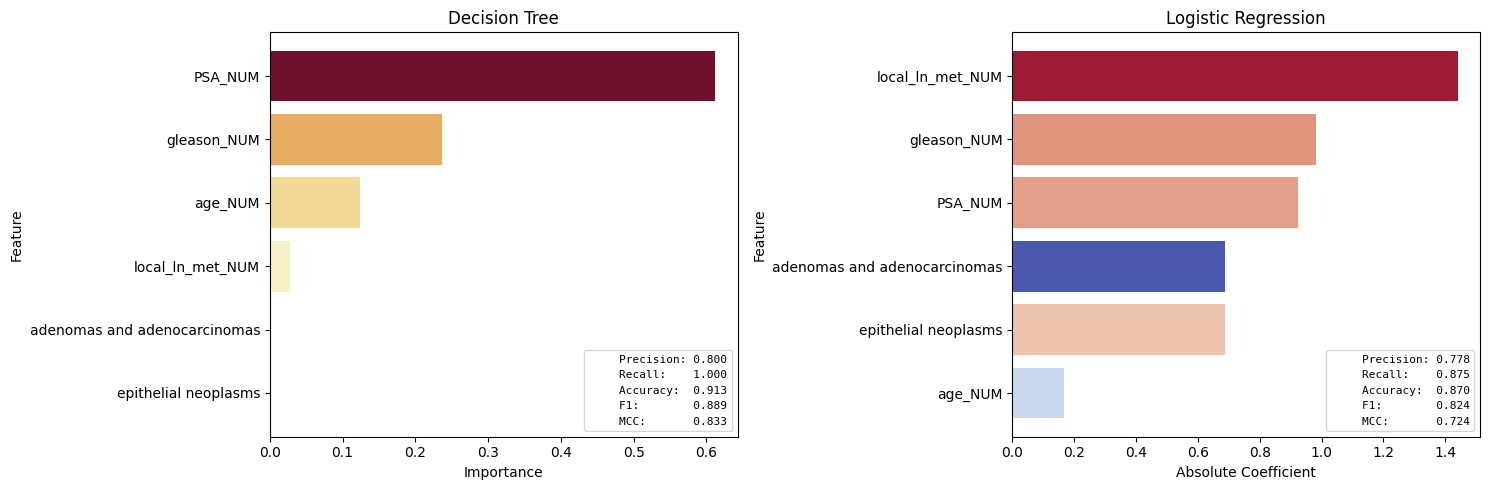

         Current function value: 0.387650
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         brain_met_BOOL   No. Observations:                  207
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.4403
Time:                        22:00:29   Log-Likelihood:                -80.244
converged:                      False   LL-Null:                       -143.36
Covariance Type:            nonrobust   LLR p-value:                 7.954e-25
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            7.3260        nan        nan        nan         nan         nan
PSA_NUM    

/home/grace/work/SEER/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [108]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from sklearn import tree
# from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# dtable = dtable.sort_values('brain_met')
preds = dtable.drop(columns=[RESPONSE]).columns.to_list()
X_train, X_test, y_train, y_test = train_test_split(dtable[preds], dtable[RESPONSE], test_size=0.10, random_state=42)
print(X_train.head())
print(y_train.head())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

### DECISION TREE ###
# fit model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# feature importances
feature_importance = pd.DataFrame({
    'Feature': preds,
    'Coefficient': clf.feature_importances_,
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# plot
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', hue='Coefficient', palette='YlOrRd', legend=False, ax=axes[0])
axes[0].plot([], [], ' ', label=f"Precision: {precision_score(y_test, y_pred):.3f}")
axes[0].plot([], [], ' ', label=f"Recall:    {recall_score(y_test, y_pred):.3f}")
axes[0].plot([], [], ' ', label=f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
axes[0].plot([], [], ' ', label=f"F1:        {f1_score(y_test, y_pred):.3f}")
axes[0].plot([], [], ' ', label=f"MCC:       {matthews_corrcoef(y_test, y_pred):.3f}")
axes[0].legend(loc='lower right', prop={'family': 'monospace', 'size': 8})
axes[0].set_title("Decision Tree")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

### LOGISTIC REGRESSION ###
# scaling continuous values? is this really needed? 
continuous_cols = []
for col in dtable.columns:
    if dtable[col].nunique() >= 3:
        continuous_cols.append(col)
print(continuous_cols)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

# fit model
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# feature importance
feature_names = X_train.columns
coefficients = clf.coef_[0]  # Shape is (1, n_features) for binary classification
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# plot
sns.barplot(data=feature_importance, x='Abs_Coefficient', y='Feature', hue='Coefficient', palette='coolwarm', legend=False, ax=axes[1])
axes[1].plot([], [], ' ', label=f"Precision: {precision_score(y_test, y_pred):.3f}")
axes[1].plot([], [], ' ', label=f"Recall:    {recall_score(y_test, y_pred):.3f}")
axes[1].plot([], [], ' ', label=f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
axes[1].plot([], [], ' ', label=f"F1:        {f1_score(y_test, y_pred):.3f}")
axes[1].plot([], [], ' ', label=f"MCC:       {matthews_corrcoef(y_test, y_pred):.3f}")
axes[1].legend(loc='lower right', prop={'family': 'monospace', 'size': 8})
axes[1].set_title("Logistic Regression")
axes[1].set_xlabel("Absolute Coefficient")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

### STATSMODELS LOGIT ###
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
result = logit_model.fit()
print(result.summary())

<Axes: xlabel='gleason_CAT', ylabel='Count'>

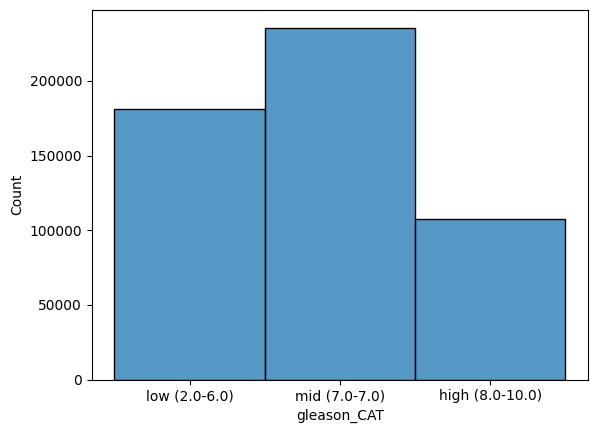

In [45]:
sns.histplot(table, x='gleason_CAT')

<Axes: xlabel='PSA_CAT', ylabel='Count'>

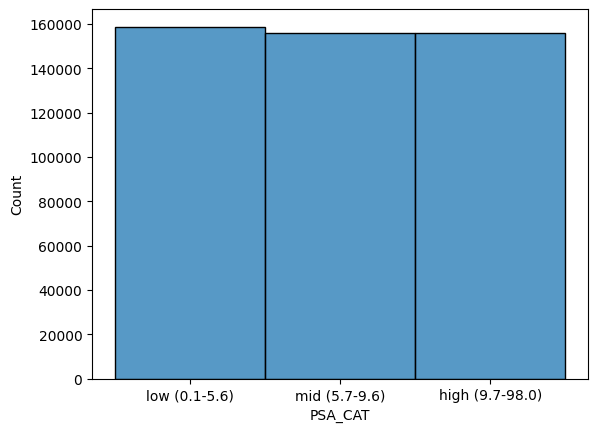

In [46]:
sns.histplot(table, x='PSA_CAT')

In [ ]:

# print(f"Precision: {precision_score(y_test, y_pred):.3f}")
# print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
# print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
# print(f"F1:        {f1_score(y_test, y_pred):.3f}")
# print(f"MCC:       {matthews_corrcoef(y_test, y_pred):.3f}")


# print(y_test.values[:10])
# print(y_pred[:10])

# print(f"Precision: {precision_score(y_test, y_pred):.3f}")
# print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
# print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
# print(f"F1:        {f1_score(y_test, y_pred):.3f}")
# print(f"MCC:       {matthews_corrcoef(y_test, y_pred):.3f}")

# print(y_test[:10].to_list())
# print(list(y_pred[:10]))

# fig = plt.figure(figsize=(24, 4), dpi=600)
# tree.plot_tree(clf, feature_names=preds, class_names=['No Met', 'Brain Met'], filled=True)
# plt.plot([], [], ' ', label=f"Precision: {precision_score(y_test, y_pred):.2f}")
# plt.plot([], [], ' ', label=f"Recall:    {recall_score(y_test, y_pred):.2f}")
# plt.plot([], [], ' ', label=f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
# plt.plot([], [], ' ', label=f"F1:        {f1_score(y_test, y_pred):.2f}")
# plt.plot([], [], ' ', label=f"MCC:       {matthews_corrcoef(y_test, y_pred):.2f}")
# plt.legend(loc='upper left', prop={'family': 'monospace', 'size': 8})
# plt.title(f"Lung and Bronchus")
# plt.savefig('/home/grace/work/SEER/outputs/figure3/lung_tree.png')
# plt.show()


gleason_CAT
mid (7.0-7.0)      235661
low (2.0-6.0)      180957
high (8.0-10.0)    107791
Name: count, dtype: int64

## Categorical

Clean and filter DataFrame

In [ ]:
# CTYPE = 'Prostate'
CTYPE = 'Lung and Bronchus'
RESPONSE = 'brain_met'
df = table[table['cancer_group']==CTYPE].copy()
df = df[df[RESPONSE].notna()].copy()

# define fields
PREDICTORS = []
PREDICTORS += ['age_bin', 'local_ln_met'] # omitted GSTAGE_STD_FMT
PREDICTORS += constants.UNIVERSAL_PREDICTORS_CATEGORICAL
PREDICTORS.remove('age')
PREDICTORS.remove('sex')
PREDICTORS.remove('GSTAGE_STD')
PREDICTORS.remove('NSTAGE_STD')
# # prostate 
# PREDICTORS.remove('GRADE_STD')
if CTYPE in constants.SPECIFIC_PREDICTORS_CATEGORICAL:
    PREDICTORS += constants.SPECIFIC_PREDICTORS_CATEGORICAL[CTYPE]
if CTYPE in constants.SPECIFIC_PREDICTORS_CONTINUOUS:
    contpreds = constants.SPECIFIC_PREDICTORS_CONTINUOUS[CTYPE]
    PREDICTORS += [CATEGORICAL_FIELDLABELS_LUT[pred] for pred in contpreds]
# Lung 
# PREDICTORS.remove('pleural_invasion')

for field in PREDICTORS:
    print(field)
# # uncomment to check which fields to use
# tmp = df[df[RESPONSE]==True]
# for field in predictors:
#     print()
#     print(tmp[field].value_counts(dropna=False))

# imputation
IMPUTE_FIELDS_LUT = {
    'TSTAGE_STD': 'T1',
    'age_bin': '60-79 years', # NOTE: This must be manually set when changing age_bin binwidth.
    
    # lung 
    # 'GRADE_STD': 'G1',
    # 'GSTAGE_STD_FMT': 'stage-I',
    # 'distant_ln_met': False,
    # 'pleural_invasion': 'PL0',
    
    # prostate
    # 'PSA_cat': 'mid (5.7-9.7)',
    # 'gleason_cat': 'mid (7.0-7.0)',
}
for field, imputed_val in IMPUTE_FIELDS_LUT.items():
    mask = df[field].isna()
    df.loc[mask, field] = imputed_val

# filtering
print(f"{df.shape[0]}\t(start)")
for field in PREDICTORS:
    df = df[df[field].notna()]
print(f"{df.shape[0]}\t(end)")

# remapping categorical values for clarity
CATVAL_MAP_LUT = {
    # # prostate
    # 'PSA_cat': lambda x: f"{x.split(' ')[0]} PSA",
    # 'gleason_cat': lambda x: f"{x.split(' ')[0]} gleason",
}
for field, func in CATVAL_MAP_LUT.items():
    df[field] = df[field].apply(func)
    print()
    print(df[field].value_counts(dropna=False))

# remove low abundance histological types
MIN_OBSERVATIONS = 10
hcounts = df[df[RESPONSE]==True]['hist_group'].value_counts()
print()
print(hcounts)
valid = hcounts[hcounts>MIN_OBSERVATIONS].index.to_list()
df = df[df['hist_group'].isin(valid)]
print()
print(df['hist_group'].value_counts(dropna=False))

# # balance brain met cases with no brain met
# print()
# print(dfslice[RESPONSE].value_counts(dropna=False))
# dfslice = equalise_proportions(dfslice, boolfield=RESPONSE)
# print()
# print(dfslice[RESPONSE].value_counts(dropna=False))


Categorical values

In [ ]:
def gen_dtable_categorical(df: pd.DataFrame) -> pd.DataFrame:
    # define one-hot expanded fields and valid values
    boolfields = ['local_ln_met', 'distant_ln_met']
    dtable_fields = {}
    for field in sorted(PREDICTORS):
        if field in boolfields:
            dtable_fields[field] = None
        else:
            dtable_fields[field] = sorted(list(df[field].unique()))

    # generating boolean dtable
    assert df['patient_id'].nunique() == df.shape[0]
    df = df.set_index('patient_id')
    dtable = pd.DataFrame(index=df.index, dtype=bool)
    for field, fvals in dtable_fields.items():
        if fvals is None:
            dtable[field] = df[field].astype(bool)
            continue 
        for val in fvals:
            dtable[val] = False
            mask = df[field]==val
            dtable.loc[mask, val] = True
    dtable[RESPONSE] = df[RESPONSE].astype(bool)

    # sanity check 
    assert dtable.dropna().shape[0] == dtable.shape[0]
    for col in dtable.columns:
        assert dtable[col].nunique() > 1

    return dtable


### Rules (you know the rules)

In [ ]:

IFS = ' + '
MIN_ITEMSET_SUPPORT = 0.05
ASSOCIATION_METRIC = 'zhangs_metric'
ASSOCIATION_THRESH = 0.01
DISPLAY_FIELDS = ['antecedents', 'consequents', 'ante_support', 'cont_support', 'support', 'confidence', 'zhangs_metric']

merulez = []
for i in range(10):
    print(i)
    # balance brain met cases with no brain met
    # print(df.shape)
    btable = helpers.equalise_proportions(df, boolfield=RESPONSE)
    # print(btable.shape)
    dtable = gen_dtable_categorical(btable)
    # print(dtable.shape)
    # print(dtable.head(10))

    # identify itemsets
    itemsets = fpgrowth(dtable, min_support=MIN_ITEMSET_SUPPORT, use_colnames=True)

    # association rules
    rules = association_rules(itemsets, metric=ASSOCIATION_METRIC, min_threshold=ASSOCIATION_THRESH)
    rules = rules.rename(columns={'antecedent support': 'ante_support', 'consequent support': 'cont_support'})
    rules["antecedents"] = rules["antecedents"].apply(lambda x: IFS.join(list(x))).astype("unicode")
    rules["consequents"] = rules["consequents"].apply(lambda x: IFS.join(list(x))).astype("unicode")
    rules['antecedents'] = rules['antecedents'].apply(lambda x: IFS.join(sorted(x.split(IFS))))
    rules['nAntes'] = rules['antecedents'].apply(lambda x: len(x.split(IFS)))
    rules['nConts'] = rules['consequents'].apply(lambda x: len(x.split(IFS)))
    rules['nMembers'] = rules['nAntes'] + rules['nConts']
    rules = rules.sort_values(by=['confidence', 'zhangs_metric'], ascending=False)
    # rules = rules.sort_values('support', ascending=False)
    # rules = rules.sort_values('confidence', ascending=False)
    # print(rules[DISPLAY_FIELDS].head(20))

    tgt_rules = rules.copy()
    tgt_rules = tgt_rules[tgt_rules['consequents']==RESPONSE]
    nrules = tgt_rules.shape[0]
    # tgt_rules = tgt_rules.sort_values(by=['zhangs_metric', 'confidence', 'support'], ascending=False)
    tgt_rules = tgt_rules.sort_values(by=['confidence', 'support'], ascending=False)
    # print()
    # print(f"rules: {nrules}")
    # print(tgt_rules[DISPLAY_FIELDS].head(10))
    merulez.append(tgt_rules)


In [ ]:
for i, t_rulez in enumerate(merulez):
    t_rulez['run'] = f"run{i}"

all_rulez = pd.concat(merulez, ignore_index=True)
print(all_rulez.shape)
sframe = pd.DataFrame(index=list(all_rulez['antecedents'].unique()))
sframe['n_runs'] = all_rulez['antecedents'].value_counts()
sframe = sframe.sort_values('n_runs')
for field in ['ante_support', 'cont_support', 'support', 'confidence', 'zhangs_metric']:
    ptable = all_rulez.pivot(index='antecedents', columns='run', values=field)
    sframe[field] = ptable.mean(axis=1)

sframe = sframe.reset_index()
sframe = sframe.rename(columns={'index': 'features'})
# sframe['features'] = sframe['features'].apply(lambda x: x.replace(';', ' + '))
# sframe = sframe.sort_values('n_runs', ascending=False)
sframe = sframe.sort_values('confidence', ascending=False)
# sframe = sframe.sort_values('zhangs_metric', ascending=False)
sframe.head(20)

In [ ]:
import matplotlib.pyplot as plt

sframe = sframe.head(18)
labels = sframe.index.to_list()
cmap = plt.get_cmap('Dark2')
colors = [cmap(i) for i in range(8)] * 3
markers = ['D', 'o', 's'] * 6

plt.figure(figsize=(5, 5))
for i, rec in enumerate(sframe.itertuples()):
    plt.plot(rec.zhangs_metric, rec.confidence, color=colors[i], marker=markers[i], markersize=7, label=rec.features, linestyle='None', mec='white', mew=0.8)
plt.title('ARL')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Zhangs')
plt.ylabel('Confidence')
plt.show()

# marker_lut

# mapper = {}
# for i in range(6):
#     for j in range(3):
#         label = labels[i+j]
#         color = cmap(i)
#         marker = markers[j]
#         mapper[label] = {'color': color, 'marker': marker}


# plt.scatter(x_values, y_values)
# plt.show()

In [ ]:
all_rulez[all_rulez['antecedents']=='adenomas and adenocarcinomas;distant_ln_met;mid gleason']

<br><br><br>

-------------
### CHOPPED SHYT

In [ ]:

# # imputation / filtering
# IMPUTE_LUT = {
#     'TSTAGE_STD': 'T1',
#     'age_bin': '60-79 years', # NOTE: This must be manually set when changing age_bin binwidth.
#     # 'GRADE_STD': 'G1',
#     # 'GSTAGE_STD_FMT': 'stage-I',
#     # 'distant_ln_met': False,
#     # 'pleural_invasion': 'PL0',
#     'pleural_invasion': None,
#     'GRADE_STD': None,
#     'distant_ln_met': None,
#     'hist_group': None, 
#     'local_ln_met': None, 
#     'sex': None, 
# }

# print(f"{dfslice.shape[0]}\t(start)")
# for field, ival in IMPUTE_LUT.items():
#     validvals = VALIDVALS_LUT[field]
#     # print()
#     # print(field)
#     # for val in validvals:
#     #     print(f"- {val} ({type(val)})")
#     if ival is None:
#         dfslice = dfslice[dfslice[field].isin(validvals)]
#     else:
#         mask = ~dfslice[field].isin(validvals)
#         dfslice.loc[mask, field] = ival
#     # print(f"{dfslice.shape[0]}\t({field})")
# print(f"{dfslice.shape[0]}\t(end)")

# # balance brain met cases with no brain met
# dfslice = equalise_proportions(dfslice, boolfield=RESPONSE)

# # sanity check 
# for field, validvals in VALIDVALS_LUT.items():
#     print()
#     print(dfslice[field].value_counts(dropna=False))
#     assert sorted(list(dfslice[field].unique())) == validvals



In [ ]:
# for cancer_group, predictors in constants.SPECIFIC_PREDICTORS_CONTINUOUS.items():
#     for pred in predictors:
#         print()
#         print(cancer_group, pred)
#         dfslice = table[table['cancer_group']==cancer_group].copy()
        
#         # numeric
#         fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
#         nunique = dfslice[pred].nunique()
#         sns.histplot(data=dfslice, x=pred, bins=min(nunique, 10), ax=axes[0])

#         # mask and valid values
#         mask = dfslice[pred].notna()
#         validvals = dfslice[mask][pred]
        
#         # mapped to categorical3 
#         newfield = f"{pred}_cat3"
#         dfslice[newfield] = pd.NA 
#         dfslice.loc[mask, newfield] = categorise(validvals, preferred_q=3)
#         sns.histplot(data=dfslice, x=newfield, ax=axes[1])
        
#         # mapped to categorical2 
#         newfield = f"{pred}_cat2"
#         dfslice[newfield] = pd.NA 
#         dfslice.loc[mask, newfield] = categorise(validvals, preferred_q=2)
#         sns.histplot(data=dfslice, x=newfield, ax=axes[2])
#         plt.show()

